In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("ggpubr")
library("tgstat")
library("dplyr")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.2     v purrr   0.3.4
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 1.0.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x data.table::between() masks dplyr::between()
x tidyr::expand()       masks Matrix::expand()
x dplyr::filter()       masks stats::filter()
x data.table::first()   masks dplyr::first()
x dplyr::lag()          masks stats::lag()
x data.table::last()    masks dp

In [4]:
# source("scripts/manifold_2d_proj_hr.R")
scdb_init("scrna_db/", force_reinit=T)

fig_dir <- "figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
gset_exe = scdb_gset("exe")
mc2d_exe <- scdb_mc2d(id = "exe_umap")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
gset_emb = scdb_gset("emb")
mc2d_emb <- scdb_mc2d(id = "emb_umap")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
mc2d_embexe <- scdb_mc2d(id = "embexe_recolored_umap")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to scrna_db/



In [9]:
scdb_init("scrna_db_mm10_star/", force_reinit=T)

mat_all = scdb_mat('embexe_bmp4_og2_stelzer_star')
mc_all <- scdb_mc("embexe_bmp4_og2_star")
md_all <- mat_all@cell_metadata[colnames(mat_all@mat),]

cmp_annot = readRDS('data/cmp_annot_embexe_bmp4.RData')
cmp_time = read.table("data/embexe_bmp4/time_match/time_match_summary.txt", header = T)
wt_age = read.table('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv',sep = '\t',h = T)

cmp_time = cmp_time  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))

included_colors = mc_embexe@color_key$color[c(1:38,43:50)]

initializing scdb to scrna_db_mm10_star/

Joining, by = "best_rank_query"


In [10]:
germline_ko_embryos = c("x4e26_Embryo_ExE_Bmp4_KO","x4e37_Embryo_ExE_Bmp4_KO",'x6e9_Embryo_ExE_Bmp4_KO',
                          "x4e34_Embryo_ExE_Bmp4_KO","x4e35_Embryo_ExE_Bmp4_KO")

germline_control_embryos = c('x4e19_Embryo_ExE_Bmp4_KO','x4e22_Embryo_ExE_Bmp4_KO',
                    'x4e31_Embryo_ExE_Bmp4_KO','x6e3_Embryo_ExE_Bmp4_KO',
                    'x6e2_Embryo_ExE_Bmp4_KO','x6e1_Embryo_ExE_Bmp4_KO',
                    'x6e6_Embryo_ExE_Bmp4_KO','x6e4_Embryo_ExE_Bmp4_KO')

In [11]:
tetraploid_ko_embryos = c('x7e14_Embryo_Bmp4_KO',
                          'x7e111_Embryo_Bmp4_KO',
                          'x7e17_Embryo_Bmp4_KO',
                          'x8e11_Embryo_Bmp4_KO',
                          'x8e23_Embryo_Bmp4_KO',
                          'x10e3_Embryo_Bmp4_KO',
                          'x10e1_Embryo_Bmp4_KO',
                          'x10e2_Embryo_Bmp4_KO',
                          'x10e9_Embryo_Bmp4_KO',
                          'x8e21_Embryo_Bmp4_KO',
                          'x8e22_Embryo_Bmp4_KO',
                          'x10e5_Embryo_Bmp4_KO',
                          'x10e7_Embryo_Bmp4_KO',
                          'x10e12_Embryo_Bmp4_KO',
                          'x10e13_Embryo_Bmp4_KO',
                          'x10e14_Embryo_Bmp4_KO',
                          'x10e16_Embryo_Bmp4_KO',
                          'x10e15_Embryo_Bmp4_KO')

tetraploid_control_embryos = c('x10c3_Embryo_Bmp4_KO','x10c5_Embryo_Bmp4_KO',
                        'x10c6_Embryo_Bmp4_KO','x10c10_Embryo_Bmp4_KO')

In [12]:
col_to_ct =  mc_embexe@color_key$group
names(col_to_ct) = mc_embexe@color_key$color
ct_to_col = mc_embexe@color_key$color
names(ct_to_col) = mc_embexe@color_key$group

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

In [13]:
exe_project_cells = rownames(md_embexe)[(md_embexe[,"Experiment"] != "Wildtype project") & (md_embexe$embryo %in% wt_age$embryo)]

emb_age_df = unique(md_embexe[exe_project_cells,c("embryo","transcriptional_rank","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sc_time_annot = data.frame("cell" = exe_project_cells, "embryo" = md_embexe[exe_project_cells,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

mc_time = tapply(sc_time,mc_embexe@mc[names(sc_time)],mean)

In [14]:
plot_size <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

## FIG 5b

In [15]:
bad_genes <- read.table('data/embexe.bad_genes.txt')[,1]
batch_genes <- read.table('data/bmp4_ko_expression_analysis_bad_genes.tsv')[,1]
batch_genes <- setdiff(batch_genes, grep("Ifitm", batch_genes, v = T))

bad_gns <- unique(c(grep("Hsp", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("BEX", rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("MT", rownames(mat_all@mat),v=T, ignore.case = T),
                             grep("CDK",rownames(mat_all@mat),v=T, ignore.case = T),
                            grep("RN[0-9]", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Nduf", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("Mrp", rownames(mat_all@mat),v=T, ignore.case = T),
                    grep("\\bcox", rownames(mat_all@mat),v=T, ignore.case = T),
                     grep("\\bRp[l|s]", rownames(mat_all@mat),v=T, ignore.case = T),
                    "Top2a", "Ube2c", "Pcna", "Mki67", "Cenpf","Hist1h1a", "Hist1h1b"))

bad_genes <- union(bad_genes, bad_gns)
bad_genes <- union(bad_genes, batch_genes)

genes_f <- rownames(mat_all@mat)[! rownames(mat_all@mat) %in% bad_genes]

In [16]:
all_included_cells = names(mc_all@mc)[mc_all@colors[mc_all@mc] %in% included_colors]

wt_cells = names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% included_colors]
wt_cells = wt_cells[ !is.na(mat_all@cell_metadata[wt_cells,"developmental_time"])]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"Experiment"] != "Wildtype project"]
wt_cells = wt_cells[mat_all@cell_metadata[wt_cells,"developmental_time"] > 7.9]
wt_cells = intersect(wt_cells, names(mc_all@mc))

germline_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% germline_ko_embryos]
germline_ko_cells <- intersect(germline_ko_cells, all_included_cells)

germline_ctrl_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% germline_control_embryos]
germline_ctrl_cells <- intersect(germline_ctrl_cells, all_included_cells)

tetraploid_ko_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_ko_embryos]
tetraploid_ko_cells <- intersect(tetraploid_ko_cells, all_included_cells)

tetraploid_ctrl_cells <- rownames(mat_all@cell_metadata[names(mc_all@mc),])[mat_all@cell_metadata[names(mc_all@mc),"embryo"] %in% tetraploid_control_embryos]
tetraploid_ctrl_cells <- intersect(tetraploid_ctrl_cells, all_included_cells)

In [17]:
gexp_per_col_WT <- t(tgs_matrix_tapply(x = mat_all@mat[genes_f,wt_cells],
                         index = mc_all@colors[mc_all@mc[wt_cells]],
                         fun = sum))

gexp_per_col_WT <- t(t(gexp_per_col_WT)/colSums(gexp_per_col_WT))
l_gexp_per_col_WT <- log2(gexp_per_col_WT + 3e-5)

################################################################################################################################

gexp_per_col_emb_KO = t(tgs_matrix_tapply(x = mat_all@mat[genes_f,tetraploid_ko_cells],
                         index = mc_all@colors[mc_all@mc[tetraploid_ko_cells]],
                         fun = sum))

gexp_per_col_emb_KO = t(t(gexp_per_col_emb_KO)/colSums(gexp_per_col_emb_KO))
l_gexp_per_col_emb_KO = log2(gexp_per_col_emb_KO + 3e-5)

################################################################################################################################

gexp_per_col_embexe_KO = t(tgs_matrix_tapply(x = mat_all@mat[genes_f,germline_ko_cells],
                         index = mc_all@colors[mc_all@mc[germline_ko_cells]],
                         fun = sum))

gexp_per_col_embexe_KO = t(t(gexp_per_col_embexe_KO)/colSums(gexp_per_col_embexe_KO))
l_gexp_per_col_embexe_KO = log2(gexp_per_col_embexe_KO + 3e-5)

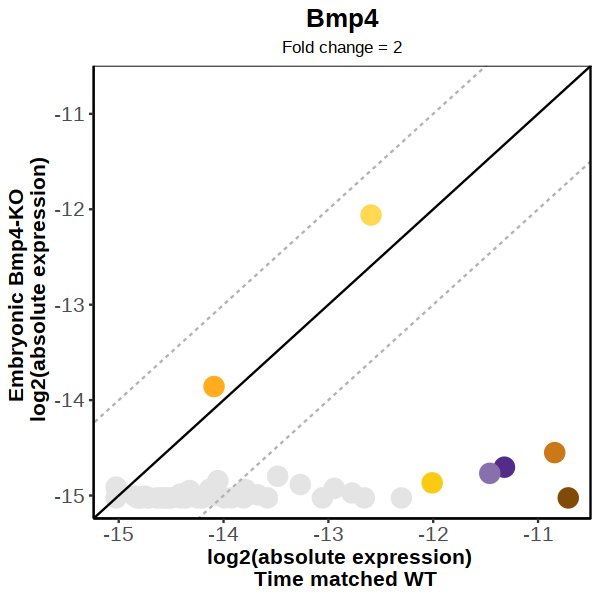

In [18]:
plot_size(5,5)
gene = "Bmp4"
fc = 1

relevant_cell_type_cols <- intersect(colnames(l_gexp_per_col_emb_KO),colnames(l_gexp_per_col_WT))
df = data.frame(WTs = as.vector(l_gexp_per_col_WT[gene,relevant_cell_type_cols]), 
            KOs = as.vector(l_gexp_per_col_emb_KO[gene,relevant_cell_type_cols]),
            col = relevant_cell_type_cols)

bmp4_expressin_ct_cols <- c("#FACB12","#ffd854","#ffad1e","#532C8A","#8870ad","#cc7818","#824A09")
df[! df$col %in% bmp4_expressin_ct_cols,"col"] <- "#E4E4E4"

ylab = "Embryonic Bmp4-KO \n log2(absolute expression)"
xlab = "log2(absolute expression) \n Time matched WT"

ymax <- max(c(l_gexp_per_col_emb_KO[gene,],l_gexp_per_col_WT[gene,]))
lims <- c(log2(3e-5), ymax)

p <- ggplot(data = df,aes(WTs,KOs, col=col)) +
geom_point(size = 5) +
        geom_abline(slope = 1,intercept = 0) +
          geom_abline(slope = 1,intercept = fc, col = "gray70",linetype = 'dashed') +
          geom_abline(slope = 1,intercept = -fc, col = "gray70",linetype = 'dashed') +
          
        xlim(lims) +
        ylim(lims) +
           ggtitle(label = gene, subtitle = sprintf("Fold change = %s",round(2^fc, 0))) +
          scale_color_identity() +
          ylab(ylab) +
          xlab(xlab) +
          theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 15),
                axis.text = element_text(size = 12),
                plot.subtitle = element_text(hjust = 0.5, size = 10),
                axis.title = element_text(face = "bold",size = 12),
                panel.grid = element_blank(),panel.border = element_rect(fill=NA),legend.position="None")

print(p)

## FIG 5c-d

In [19]:
mutants_df <- read.csv("data/embs_bmp4_muts.csv")
embryonic_ko_ind <- grep("4n_x", x = mutants_df$plate, ignore.case = T)
germline_ko_ind <- grep("germline_x", x = mutants_df$plate, ignore.case = T)

embryonic_ko_df <- mutants_df[ embryonic_ko_ind,]
embryonic_ko_df <- embryonic_ko_df %>% left_join(cmp_time %>% select(embryo,developmental_time))

germline_ko_df <- mutants_df[ germline_ko_ind,]
germline_ko_df <- germline_ko_df %>% left_join(cmp_time %>% select(embryo,developmental_time))

Joining, by = "embryo"
Joining, by = "embryo"


In [20]:
wt_emb_vs_ct = table(mat_all@cell_metadata[wt_cells,"transcriptional_rank"],
                     factor(x = mc_all@colors[mc_all@mc[wt_cells]],levels = mc_embexe@color_key$color[1:38]))

wt_emb_vs_ctn = wt_emb_vs_ct/rowSums(wt_emb_vs_ct)

In [21]:
germline_time <- array(data = cmp_time[ cmp_time$embryo %in% germline_ko_embryos,"developmental_time"], 
                       dimnames = list(cmp_time[ cmp_time$embryo %in% germline_ko_embryos,"embryo"]))
germline_time <- germline_time[order(as.numeric(germline_time))]

embexe_ko_ct = table( mat_all@cell_metadata[germline_ko_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[germline_ko_cells],levels = mc_embexe@color_key$color[1:38]))
embexe_ko_ctn = embexe_ko_ct/rowSums(embexe_ko_ct)
embexe_ko_ctn <- embexe_ko_ctn[names(germline_time),]

In [22]:
tetraploid_time <- array(data = cmp_time[ cmp_time$embryo %in% tetraploid_ko_embryos,"developmental_time"], 
                       dimnames = list(cmp_time[ cmp_time$embryo %in% tetraploid_ko_embryos,"embryo"]))
tetraploid_time <- tetraploid_time[order(as.numeric(tetraploid_time))]

emb_ko_ct = table( mat_all@cell_metadata[ tetraploid_ko_cells,"embryo"],
                     factor(x = cmp_annot$query_cls_col[tetraploid_ko_cells],levels = mc_embexe@color_key$color[1:38]))

emb_ko_ctn = emb_ko_ct/rowSums(emb_ko_ct)
emb_ko_ctn <- emb_ko_ctn[names(tetraploid_time),]

In [23]:
germline_ko_embryos_old <- unique(germline_ko_df[germline_ko_df$embryo %in% germline_ko_embryos & germline_ko_df$developmental_time > 7.9,"embryo"])
tetraploid_ko_embryos_old <- unique(embryonic_ko_df[embryonic_ko_df$embryo %in% tetraploid_ko_embryos & embryonic_ko_df$developmental_time > 7.9,"embryo"])

emb_ko_ctn <- emb_ko_ctn[tetraploid_ko_embryos_old,]
embexe_ko_ctn <- embexe_ko_ctn[germline_ko_embryos_old,]

coarse_grained_types = mc_embexe@color_key$group[c(1:38)]
names(coarse_grained_types) = mc_embexe@color_key$group[c(1:38)]

coarse_grained_types[c("Erythroid 1","Erythroid 2","Erythroid 3")] = "Erythroid"
coarse_grained_types[c("Definitive endoderm","Gut","Hindgut")] = "Endoderm"
coarse_grained_types[c("Amnion/Chorion progenitor","Amnion/Chorion")] = "Amnion/Chorion lineage"

included_cell_types = c("Amnion/Chorion lineage",
                        "ExE mesoderm",
                        "Allantois",
                        "PGC",
                        "Erythroid",
                        "Endoderm")

emb_ko_ctn_coarse = t(tgs_matrix_tapply(as.matrix(as.data.frame.matrix(emb_ko_ctn)),coarse_grained_types,sum))
embexe_ko_ctn_coarse = t(tgs_matrix_tapply(as.matrix(as.data.frame.matrix(embexe_ko_ctn)),coarse_grained_types,sum))
wt_emb_vs_ctn_coarse = t(tgs_matrix_tapply(as.matrix(as.data.frame.matrix(wt_emb_vs_ctn)),coarse_grained_types,sum))

In [24]:
df_emb_ko_coarse = as.data.frame.table(emb_ko_ctn_coarse)
colnames(df_emb_ko_coarse) = c("embryo","cell_type","frequency")
df_emb_ko_coarse$genotype = "Embryonic Bmp4-KO"

df_embexe_ko_coarse = as.data.frame.table(embexe_ko_ctn_coarse)
colnames(df_embexe_ko_coarse) = c("embryo","cell_type","frequency")
df_embexe_ko_coarse$genotype = "Germline Bmp4-KO"

df_wt_coarse = as.data.frame.table(wt_emb_vs_ctn_coarse)
colnames(df_wt_coarse) = c("embryo","cell_type","frequency")
df_wt_coarse$genotype = "Time matched WT"

df_all_ct_coarse = rbind(df_emb_ko_coarse,df_wt_coarse,df_embexe_ko_coarse)

In [25]:
Bmp4_emb_to_wt_p_values = sapply(included_cell_types,function(ct) {
    
    p_val = wilcox.test(x = emb_ko_ctn_coarse[,ct],y = wt_emb_vs_ctn_coarse[,ct])
    return(p_val$p.value)
})

Bmp4_embexe_to_wt_p_values = sapply(included_cell_types,function(ct) {
    
    p_val = wilcox.test(x = embexe_ko_ctn_coarse[,ct],y = wt_emb_vs_ctn_coarse[,ct])
    return(p_val$p.value)
})

# p value PGCs: use chi square test instead of wilcoxon rank sum test because of zero inflation
pgc_color = "#FACB12"
wt_frequency = sum(wt_emb_vs_ct[,pgc_color])/sum(wt_emb_vs_ct)
bmp4_emb_frequency = sum(emb_ko_ct[,pgc_color])
bmp4_embexe_frequency = sum(embexe_ko_ct[,pgc_color])
wt_frequency = c(wt_frequency,1 - wt_frequency)
bmp4_emb_frequency = c(bmp4_emb_frequency,sum(emb_ko_ct) - bmp4_emb_frequency)
bmp4_embexe_frequency = c(bmp4_embexe_frequency,sum(embexe_ko_ct) - bmp4_embexe_frequency)

p_val_pgc_emb = chisq.test(x = bmp4_emb_frequency,p = wt_frequency)
p_val_pgc_embexe = chisq.test(x = bmp4_embexe_frequency,p = wt_frequency)

Warning message in wilcox.test.default(x = emb_ko_ctn_coarse[, ct], y = wt_emb_vs_ctn_coarse[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = emb_ko_ctn_coarse[, ct], y = wt_emb_vs_ctn_coarse[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = emb_ko_ctn_coarse[, ct], y = wt_emb_vs_ctn_coarse[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = embexe_ko_ctn_coarse[, ct], y = wt_emb_vs_ctn_coarse[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(x = embexe_ko_ctn_coarse[, ct], y = wt_emb_vs_ctn_coarse[, :
"cannot compute exact p-value with ties"


In [26]:
library("qvalue")

Bmp4_emb_to_wt_p_values["PGC"] = p_val_pgc_emb$p.value
Bmp4_embexe_to_wt_p_values["PGC"] = p_val_pgc_embexe$p.value

q_value_Bmp4_emb = qvalue(p = Bmp4_emb_to_wt_p_values,pi0 = 1)$qvalues
q_value_Bmp4_embexe = qvalue(p = Bmp4_embexe_to_wt_p_values,pi0 = 1)$qvalues

In [27]:
q_to_signif = function(v) {
v_signif = sapply(v,function(x) {

  if(x >= 0.05) {
    a = "ns"
  } else {
    a = "*"
  }
  return(a)
})
return(v_signif)
}

In [28]:
stat_comparison = data.frame(group1 = c(rep("Embryonic Bmp4-KO",length(included_cell_types)),rep("Germline Bmp4-KO",length(included_cell_types))),
                           group2 = rep("Time matched WT",2*length(included_cell_types)),
                           cell_type = c(names(q_value_Bmp4_emb),names(q_value_Bmp4_embexe)),
                           q.val = c(q_value_Bmp4_emb,q_value_Bmp4_embexe),
                           q.signif = c(q_to_signif(q_value_Bmp4_emb),q_to_signif(q_value_Bmp4_embexe)))

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



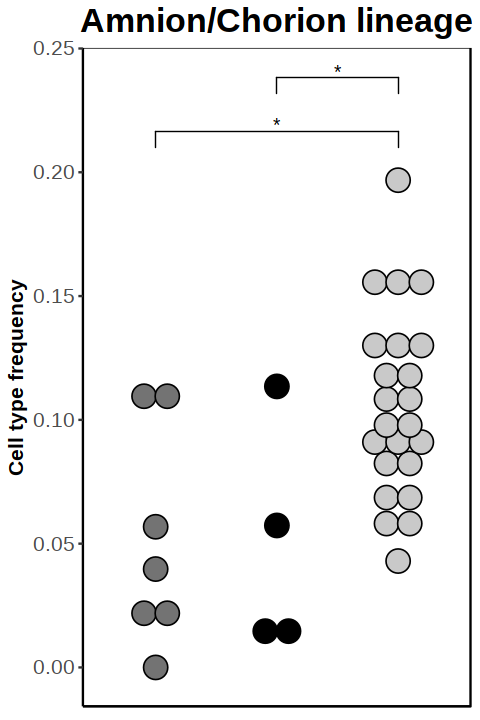

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



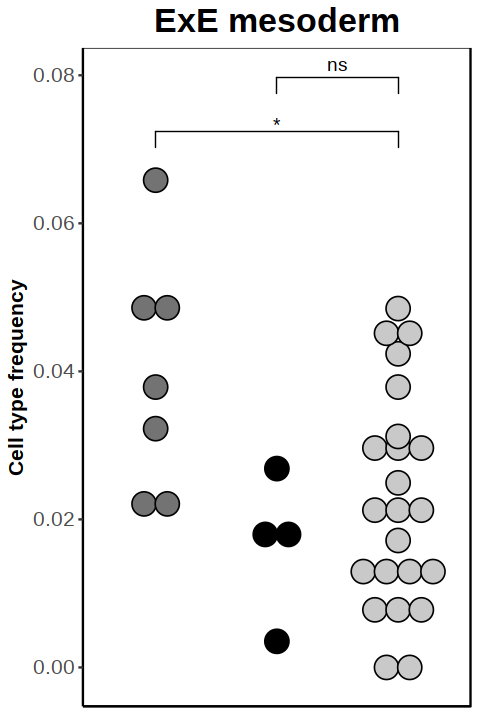

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



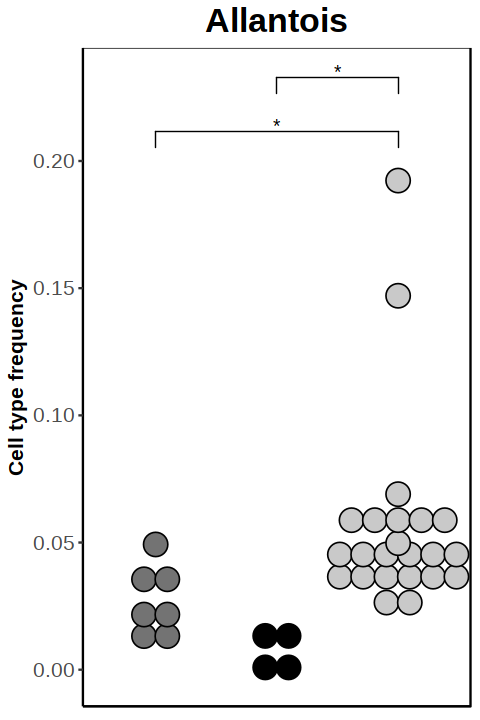

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



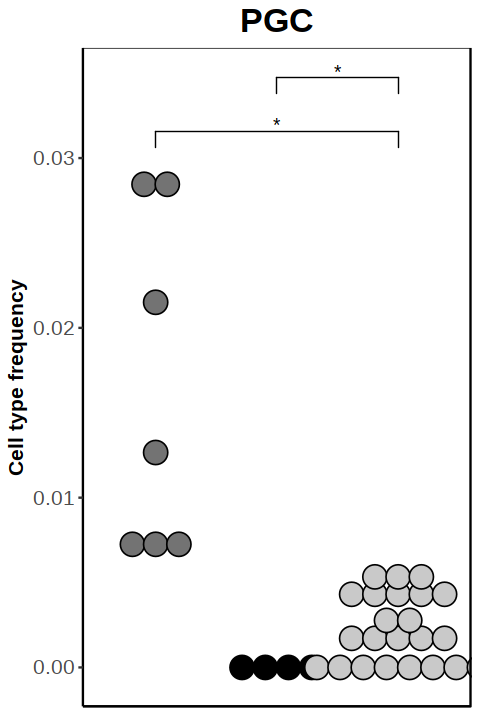

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



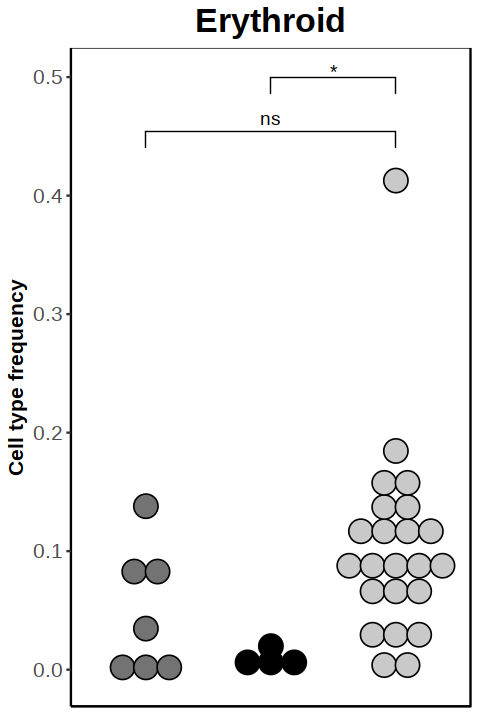

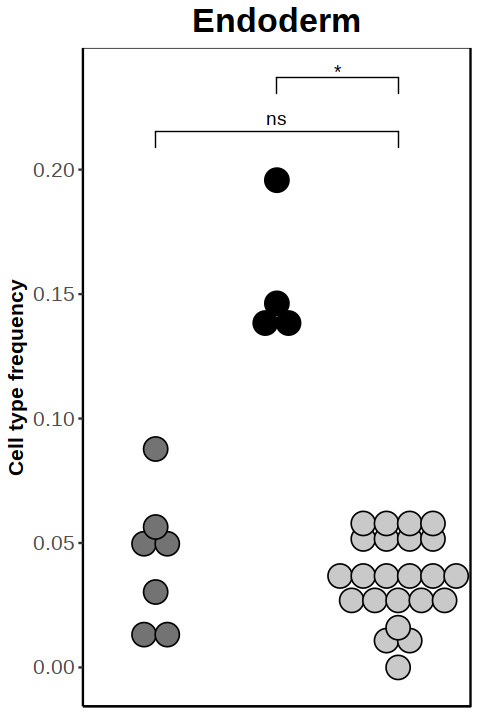

In [29]:
options(repr.plot.width=4, repr.plot.height=6)
for(ct in included_cell_types) {
    
    Ct <- gsub("/| |-", replacement = "_", x = ct)
    f = df_all_ct_coarse$cell_type == ct
    stat_f = stat_comparison[stat_comparison$cell_type == ct,]
    p = ggplot(df_all_ct_coarse[f,],aes(x = genotype,y = frequency)) + 
    stat_pvalue_manual(stat_f,y.position = max(df_all_ct_coarse$frequency[f])*1.1,step.increase = 0.1,label = "q.signif") +
        geom_dotplot(aes(fill = genotype),dotsize = 1.3,binaxis = "y",stackdir = "center",show.legend = F) +
        ggtitle(label = ct) + ylab("Cell type frequency") +

        scale_fill_manual(values = c("Time matched WT" = "#C9C9C9",
                                     "Germline Bmp4-KO" = "black",
                                     "Embryonic Bmp4-KO" = "#737373")) +

        theme(plot.title = element_text(face = "bold",hjust = 0.5, size = 20),
                axis.text.y = element_text(size = 12),
                plot.subtitle = element_text(hjust = 0.5, size = 10),
                axis.title.y = element_text(face = "bold",size = 12),
              axis.title.x = element_blank(),
              axis.ticks.x = element_blank(),
              axis.text.x = element_blank(),
                panel.grid = element_blank(),
                panel.border = element_rect(fill=NA),
                legend.position="None")
print(p)
}

## FIG 5e

In [30]:
included_colors = mc_embexe@color_key$color[1:38]
wt_cells_all = names(mc_embexe@mc)[mc_embexe@colors[mc_embexe@mc] %in% included_colors]
wt_cells_all = wt_cells_all [ !is.na(mat_embexe@cell_metadata[wt_cells_all,"developmental_time"])]

In [31]:
all_query_cells = names(cmp_annot$query_cls_col)[cmp_annot$query_cls_col %in% included_colors]
bmp4_emb_ko_cells_all = all_query_cells[ mat_all@cell_metadata[all_query_cells,"embryo"] %in% tetraploid_ko_embryos]

In [32]:
emb_ko_ct = table( mat_all@cell_metadata[bmp4_emb_ko_cells_all,"embryo"],factor(x = col_to_ct[cmp_annot$query_cls_col[ bmp4_emb_ko_cells_all]],levels = col_to_ct[included_colors]))

In [33]:
min_number_of_query_cells_per_cell_type = 9
vector_of_selected_cell_types = c("ExE mesoderm","Allantois")

In [34]:
egc_list_query_embryos = tapply( bmp4_emb_ko_cells_all,mat_all@cell_metadata[ bmp4_emb_ko_cells_all,"embryo"],function(query_cells) {
    
    egc_q = t(tgs_matrix_tapply(mat_all@mat[ ,query_cells], col_to_ct[ cmp_annot$query_cls_col[query_cells]],sum))
    egc_q = t(t(egc_q)/colSums(egc_q))
    
    return(egc_q)
}) 


In [35]:
ct_vector = c("ExE mesoderm","Allantois")

In [36]:
egc_list_per_ct = lapply(ct_vector,function(ct) {
    
    wt_cells_ct = wt_cells_all[ col_to_ct[mc_embexe@colors[mc_embexe@mc[wt_cells_all]]] == ct]
    wt_cells_ct = intersect(wt_cells_ct,colnames(mat_all@mat))
    
    n_cells_per_embryo = table( mat_all@cell_metadata[wt_cells_ct,"embryo"])
    embryos_ct_f = names(n_cells_per_embryo)[n_cells_per_embryo >= min_number_of_query_cells_per_cell_type]
    
    wt_cells_ct = wt_cells_ct[ mat_all@cell_metadata[wt_cells_ct,"embryo"] %in% embryos_ct_f]
    
    egc_per_embryo = t(tgs_matrix_tapply( mat_all@mat[,wt_cells_ct],mat_all@cell_metadata[wt_cells_ct,"transcriptional_rank"],sum))
    egc_per_embryo = t(t(egc_per_embryo)/colSums(egc_per_embryo))
    return(egc_per_embryo)
})
names(egc_list_per_ct) = ct_vector


In [37]:
egc_list_per_ct_ko = lapply(ct_vector,function(ct) {
    
    ko_cells_ct = bmp4_emb_ko_cells_all[ col_to_ct[ cmp_annot$query_cls_col[bmp4_emb_ko_cells_all]] == ct]
    
    n_cells_per_embryo = table( mat_all@cell_metadata[ko_cells_ct,"embryo"])
    embryos_ct_f = names(n_cells_per_embryo)[n_cells_per_embryo >= min_number_of_query_cells_per_cell_type]
    
    ko_cells_ct = ko_cells_ct[ mat_all@cell_metadata[ko_cells_ct,"embryo"] %in% embryos_ct_f]
    
    egc_per_embryo = t(tgs_matrix_tapply( mat_all@mat[,ko_cells_ct],mat_all@cell_metadata[ko_cells_ct,"embryo"],sum))
    egc_per_embryo = t(t(egc_per_embryo)/colSums(egc_per_embryo))
    return(egc_per_embryo)
})
names(egc_list_per_ct_ko) = ct_vector


In [38]:
roll_window = 6
egc_wt_smoothed_per_time = lapply(ct_vector,function(ct) {
    
    wt_cells_ct = wt_cells_all[ col_to_ct[mc_embexe@colors[mc_embexe@mc[wt_cells_all]]] == ct]
    wt_cells_ct = intersect(wt_cells_ct,colnames(mat_all@mat))
    
    egc_per_embryo = t(tgs_matrix_tapply( mat_all@mat[,wt_cells_ct],mat_all@cell_metadata[wt_cells_ct,"transcriptional_rank"],sum))
    egc_per_embryo_smoothed = t(apply(egc_per_embryo,1,function(x) {
        return(rollmean(x = x,k = 2*roll_window + 1))
    }))
    egc_per_embryo_smoothed = t(t(egc_per_embryo_smoothed)/colSums(egc_per_embryo_smoothed))
    

    return(egc_per_embryo_smoothed)
})
names(egc_wt_smoothed_per_time) = ct_vector

In [39]:
reg = 7e-5
ylim = c(log2(reg),-9)
gene_vector = c("Hand1","Msx1","Tbx4","Snai1")

In [40]:
selected_genes = gene_vector
legc_moving_sd_per_time =  lapply(ct_vector,function(ct) {
    
    wt_cells_ct = wt_cells_all[ col_to_ct[mc_embexe@colors[mc_embexe@mc[wt_cells_all]]] == ct]
    wt_cells_ct = intersect(wt_cells_ct,colnames(mat_all@mat))
    
    egc_per_embryo = t(tgs_matrix_tapply( mat_all@mat[,wt_cells_ct],mat_all@cell_metadata[wt_cells_ct,"transcriptional_rank"],sum))
    egc_per_embryo = t(t(egc_per_embryo)/colSums(egc_per_embryo))
    legc_per_embryo = log2(egc_per_embryo + reg)
    sd_per_embryo_smoothed = t(apply(legc_per_embryo[selected_genes,],1,function(x) {
        return(rollapply(data = x,width = 2*roll_window + 1,FUN = sd))
    }))
    

    return(sd_per_embryo_smoothed)
})
names(legc_moving_sd_per_time) = ct_vector

In [41]:
ylim_max = c("Hand1" = -9,
             "Msx1" = -10,
             "Tbx4" = -10.5,
             "Snai1" = -10.8)

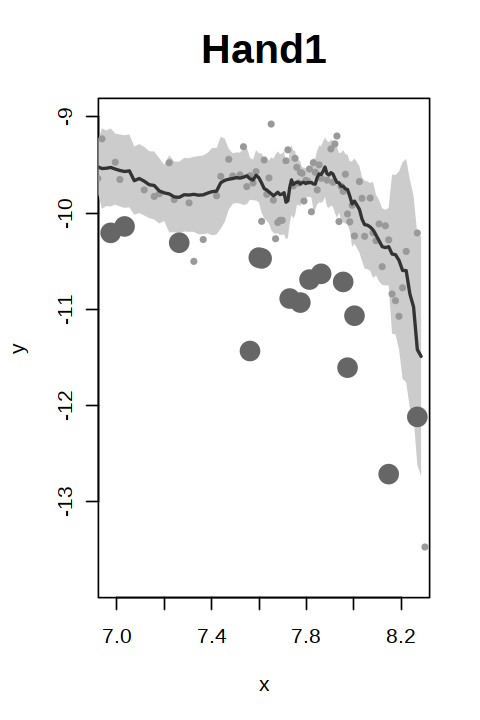

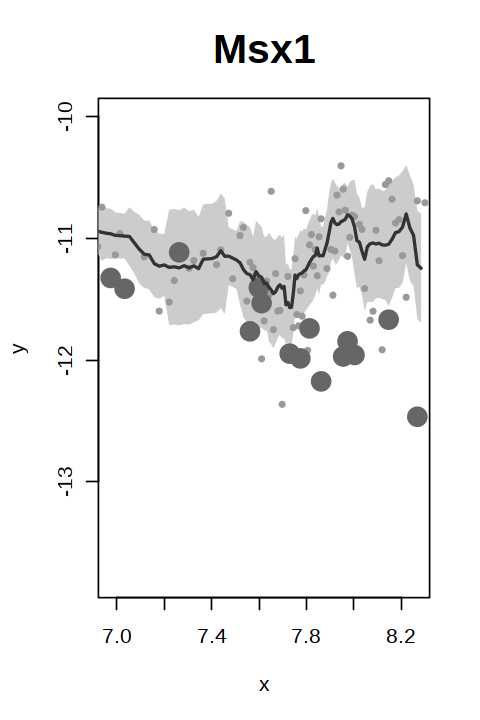

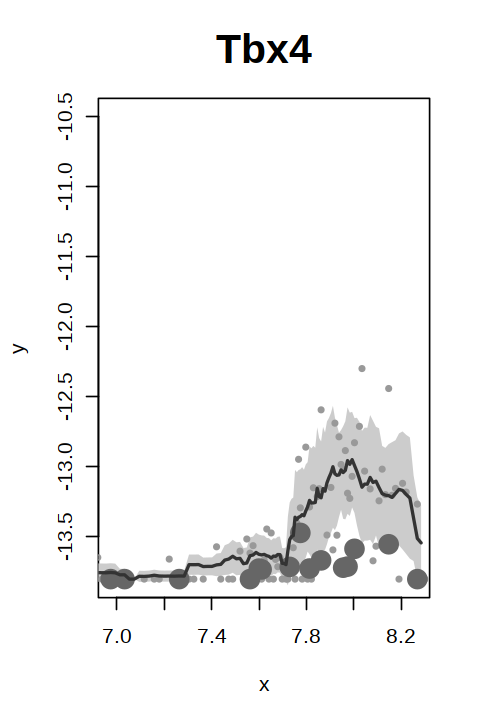

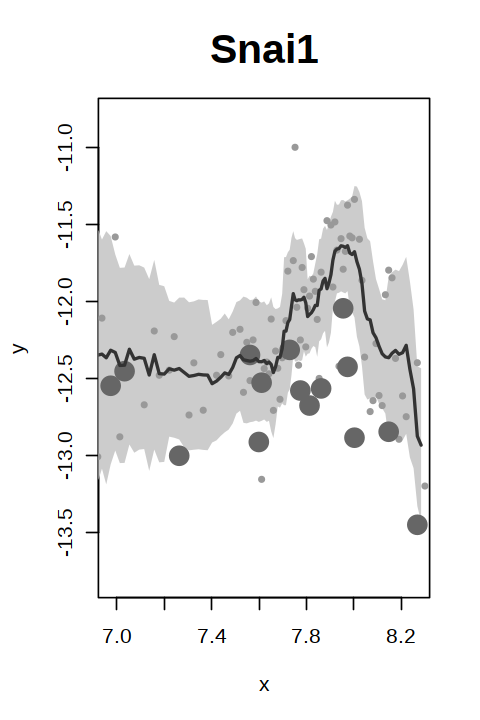

In [52]:

ct = "ExE mesoderm"
rownames(cmp_time) = cmp_time$embryo
for (gene in gene_vector) {
    query_embryos = colnames(egc_list_per_ct_ko[[ct]])
    egc_query_gene = egc_list_per_ct_ko[[ct]][gene,]
   x_time = cmp_time[query_embryos,"developmental_time"]

    #x = rep(x_time,2)
    x = x_time

#    y = c(log2(egc_query_all[gene,f_genotype & f_exe_meso] + reg),log2(egc_ref_all[gene,f_genotype & f_exe_meso] + reg))
    y = c(log2(egc_query_gene + reg))
    
    x_wt = wt_age$developmental_time[as.numeric(colnames(egc_list_per_ct[[ct]]))]

    y_wt = log2(egc_list_per_ct[[ct]][gene,] + reg)
    
    y_upper = log2(egc_wt_smoothed_per_time[[ct]][gene,] + reg) + legc_moving_sd_per_time[[ct]][gene,]
    y_lower = log2(egc_wt_smoothed_per_time[[ct]][gene,] + reg) - legc_moving_sd_per_time[[ct]][gene,]
    
    x_wt_line = wt_age$developmental_time[as.numeric(colnames(egc_wt_smoothed_per_time[[ct]]))]
    y_wt_line = log2(egc_wt_smoothed_per_time[[ct]][gene,] + reg)
  
    #ylim = c(log2(reg),max(y_wt,y_wt_line,y,-10))
    ylim = c(log2(reg),ylim_max[gene])
    #dot_color = rep(c('red','black'),each = length(x_time))
    dot_color = rep('gray40',length(x_time))

    plot(x = x,y = y,pch = 19,col = dot_color,main = gene,cex.main = 2,ylim = ylim)
    
    polygon(x = c(x_wt_line,rev(x_wt_line)),y = c(y_upper,rev(y_lower)),col = 'gray80',border = NA)

    points(x = x_wt,y = y_wt,pch = 19,col = 'gray60',cex = 0.5)
    points(x = x,y = y,pch = 19,col = dot_color,cex = 2)
   
    lines(x = x_wt_line,y = y_wt_line,lwd = 2,col = 'gray20')
    
}

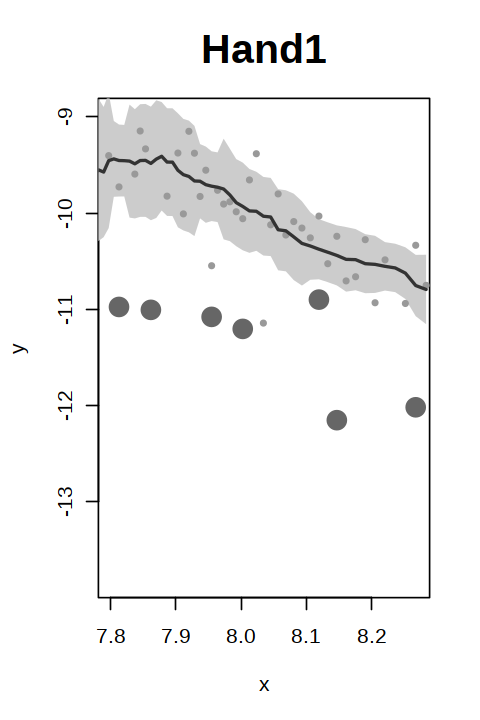

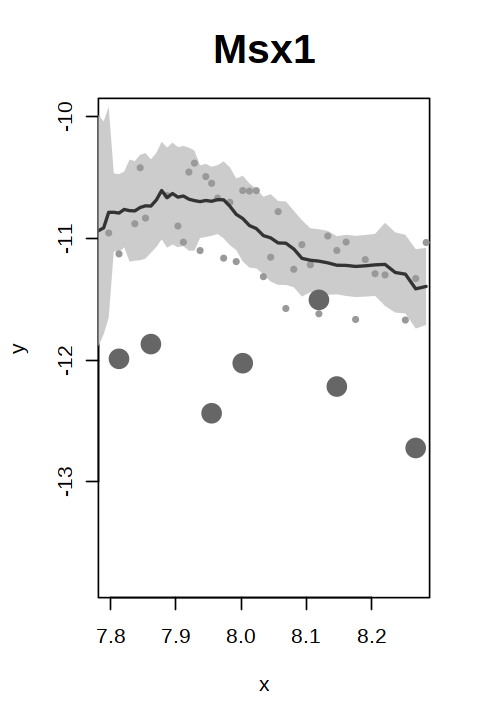

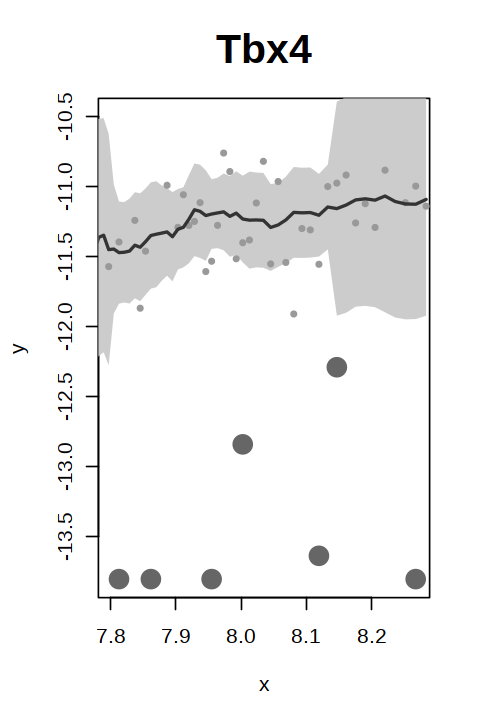

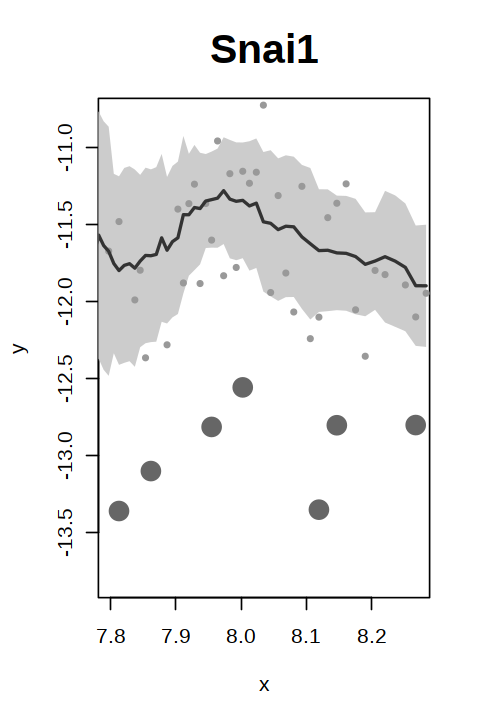

In [53]:
gene = gene_vector[1]
ct = "Allantois"
  
xlim = c(7.8,8.27)
for (gene in gene_vector) {
    query_embryos = colnames(egc_list_per_ct_ko[[ct]])
    egc_query_gene = egc_list_per_ct_ko[[ct]][gene,]
   x_time = cmp_time[query_embryos,"developmental_time"]

    #x = rep(x_time,2)
    x = x_time

#    y = c(log2(egc_query_all[gene,f_genotype & f_exe_meso] + reg),log2(egc_ref_all[gene,f_genotype & f_exe_meso] + reg))
    y = c(log2(egc_query_gene + reg))
    
    x_wt = wt_age$developmental_time[as.numeric(colnames(egc_list_per_ct[[ct]]))]

    y_wt = log2(egc_list_per_ct[[ct]][gene,] + reg)
    
    y_upper = log2(egc_wt_smoothed_per_time[[ct]][gene,] + reg) + legc_moving_sd_per_time[[ct]][gene,]
    y_lower = log2(egc_wt_smoothed_per_time[[ct]][gene,] + reg) - legc_moving_sd_per_time[[ct]][gene,]
    
    x_wt_line = wt_age$developmental_time[as.numeric(colnames(egc_wt_smoothed_per_time[[ct]]))]
    y_wt_line = log2(egc_wt_smoothed_per_time[[ct]][gene,] + reg)
  
    #ylim = c(log2(reg),max(y_wt,y_wt_line,y,-10))
    ylim = c(log2(reg),ylim_max[gene])
    #dot_color = rep(c('red','black'),each = length(x_time))
    dot_color = rep('gray40',length(x_time))

    plot(x = x,y = y,pch = 19,col = dot_color,main = gene,cex.main = 2,ylim = ylim,xlim = xlim)
    
    polygon(x = c(x_wt_line,rev(x_wt_line)),y = c(y_upper,rev(y_lower)),col = 'gray80',border = NA)

    points(x = x_wt,y = y_wt,pch = 19,col = 'gray60',cex = 0.5)
    points(x = x,y = y,pch = 19,col = dot_color,cex = 2)
   
    lines(x = x_wt_line,y = y_wt_line,lwd = 2,col = 'gray20')
    
}